<a href="https://colab.research.google.com/github/Iveynganga/Movie-Recommender-System-Capstone-Project/blob/main/MovieRecommenderProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MOVIE RECOMMENDER SYSTEM
With an ever-growing library of movies available on various platforms, users often struggle to find content that matches their tastes. This project addresses the challenge by creating a personalized movie recommendation system. The goal is to enhance user experience by suggesting movies that they are likely to find appealing based on their past viewing history and the preferences of similar users.

# Data Sourcing
The data used in this project is from a movie recommendation system dataset from Kaggle which is in Excel file format. It has 4803 entries and 23 columns.

Link: https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system/input?select=tmdb_5000_movies.csv

**Loading of data and understanding the dataset**

The first step is loading the data and understanding the dataset which involves reviewing the dataset's columns, types, and summary statistics to gain insights into the data.

In [1]:
import numpy as np
import pandas as pd

In [ ]:
credits_data = pd.read_csv('/content/tmdb_5000_credits.csv')
movies_data = pd.read_csv('/content/tmdb_5000_movies.csv')

In [ ]:
credits_data.head()

In [ ]:
movies_data.head()

In [ ]:
movies = movies_data.merge(credits_data,on="title")

movies.shape

In [ ]:
import pandas as pd

# Load the movies and credits datasets
movies_data = pd.read_csv('/content/tmdb_5000_movies.csv')
credits_data = pd.read_csv('/content/tmdb_5000_credits.csv')

# Merge the datasets on 'movie_id' to add 'cast' and 'crew' to movies_data
movies_with_credits = pd.merge(movies_data, credits_data[['movie_id', 'cast', 'crew']], left_on='id', right_on='movie_id', how='left')

# Check the first few rows of the updated dataset
movies_with_credits.head()

# Save the updated dataset to a CSV file
movies_with_credits.to_csv('movies_with_credits.csv', index=False)


In [7]:
movies_with_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   object 
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

# Key attributes

These are the most important features or columns that provide valuable information for analysis and model building


In [8]:
movies_with_credits = movies_with_credits[['budget','genres','id','popularity', 'production_companies','release_date','revenue','overview','vote_average', 'title','cast','crew']]

movies_with_credits

,budget,genres,id,popularity,production_companies,release_date,revenue,overview,vote_average,title,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",12/10/2009,2787965087,"In the 22nd century, a paraplegic Marine is di...",7.2,Avatar,NaN,NaN
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",5/19/2007,961000000,"Captain Barbossa, long believed to be dead, ha...",6.9,Pirates of the Caribbean: At World's End,NaN,NaN
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",206647,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",10/26/2015,880674609,A cryptic message from Bond’s past sends him o...,6.3,Spectre,NaN,NaN
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",49026,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",7/16/2012,1084939099,Following the death of District Attorney Harve...,7.6,The Dark Knight Rises,NaN,NaN
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",49529,43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",3/7/2012,284139100,"John Carter is a war-weary, former military ca...",6.1,John Carter,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",9367,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]",9/4/1992,2040920,El Mariachi just wants to play his guitar and ...,6.6,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",72766,0.642552,[],12/26/2011,0,A newlywed couple's honeymoon is upended by th...,5.9,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",231617,1.444476,"[{""name"": ""Front Street Pictures"", ""id"": 3958}...",10/13/2013,0,"""Signed, Sealed, Delivered"" introduces a dedic...",7.0,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,0,[],126186,0.857008,[],5/3/2012,0,When ambitious New York attorney Sam is sent t...,5.7,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


# EDA - Exploring the Dataset
EDA involves visually and statistically exploring a dataset to uncover patterns, trends, and relationships.


Which genres are the most popular in 2010-2015?

In [14]:
import pandas as pd

# Filter movies released between 2000 and 2010
movies_2000_2010 = movies_with_credits[(movies_with_credits['release_date'].dt.year >= 2000) & (movies_with_credits['release_date'].dt.year <= 2010)]

# Check if the filtering returned any rows
print("Number of movies from 2000 to 2010:", len(movies_2000_2010))

# Explode the genres
movies_2000_2010['genres'] = movies_2000_2010['genres'].apply(eval)  # Convert string representation of lists to actual lists
movies_exploded = movies_2000_2010.explode('genres')

# Check if the genres exploded correctly
print("Number of rows after exploding genres:", len(movies_exploded))

# Extract genre names and calculate the popularity of each genre
movies_exploded['genre_name'] = movies_exploded['genres'].apply(lambda x: x['name'] if isinstance(x, dict) else None)
genre_popularity = movies_exploded.groupby('genre_name')['popularity'].mean().sort_values(ascending=False)

# Display the most popular genres
print(genre_popularity)



Number of movies from 2000 to 2010: 1527
Number of rows after exploding genres: 3770
genre_name
Fantasy            20.726038
Science Fiction    19.745581
Mystery            17.886205
Adventure          17.755459
Thriller           17.239865
Horror             17.153572
Animation          17.016013
War                16.445491
Crime              16.139673
Action             15.467007
Western            15.159951
Romance            13.524714
Drama              13.077971
Family             12.560917
Music              12.338225
Comedy             12.308109
History            10.781732
TV Movie            8.832466
Documentary         4.495073
Foreign             0.886666
Name: popularity, dtype: float64


<ipython-input-14-16a0c0656bce>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_2000_2010['genres'] = movies_2000_2010['genres'].apply(eval)  # Convert string representation of lists to actual lists


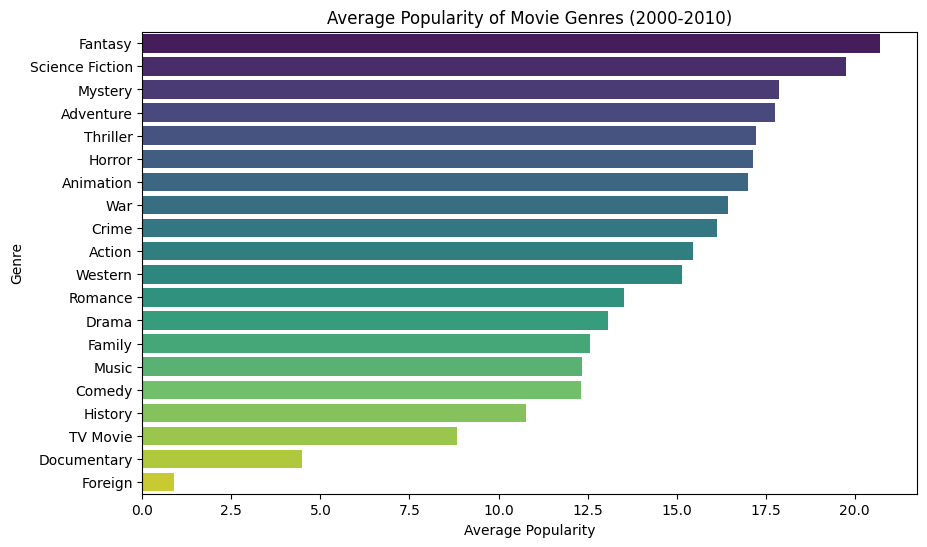

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the genre popularity
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_popularity.values, y=genre_popularity.index, hue=genre_popularity.index, palette="viridis", dodge=False, legend=False)
plt.title('Average Popularity of Movie Genres (2000-2010)')
plt.xlabel('Average Popularity')
plt.ylabel('Genre')
plt.show()

# Insights
The most popular genres in the 2000-2010 period are Fantasy, Science Fiction, Mystery, Adventure, and Thriller. These genres tend to feature high-budget, large-scale productions with wide audiences.

Fantasy and Science Fiction top the list, which may be attributed to popular movie franchises released during this time, such as Harry Potter, Avatar, and The Lord of the Rings.

Drama and Comedy, despite being common genres, have lower average popularity scores compared to genres like Fantasy and Thriller. This may reflect audience preferences for more action-packed, visually driven genres during this time.

Genres like Western, War, and History hold middle positions, while Documentary and Foreign films show very low popularity. This suggests that while these genres exist, they cater to more niche audiences.

Most common cast over the years

In [22]:
import ast
import pandas as pd

def convert_cast(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else []
    except (ValueError, SyntaxError):
        return []  # Return an empty list if the conversion fails

# Step 1: Apply safe conversion on 'cast' column
movies_with_credits['cast'] = movies_with_credits['cast'].apply(convert_cast)

# Step 2: Explode the 'cast' column
movies_exploded_cast = movies_with_credits.explode('cast')

# Step 3: Extract cast member names
movies_exploded_cast['cast_name'] = movies_exploded_cast['cast'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Step 4: Group by cast member names and count their occurrences
common_cast = movies_exploded_cast['cast_name'].value_counts()

# Display the top 10 most common cast members
print(common_cast.head(10))


cast_name
Robert De Niro       41
Samuel L. Jackson    31
Willem Dafoe         27
Susan Sarandon       26
Forest Whitaker      25
Jim Broadbent        25
Bill Murray          25
John Cusack          24
Sigourney Weaver     24
Keith David          24
Name: count, dtype: int64


<ipython-input-25-b650914649c6>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Actor', y='Movie Count', data=df, palette='Blues_d')


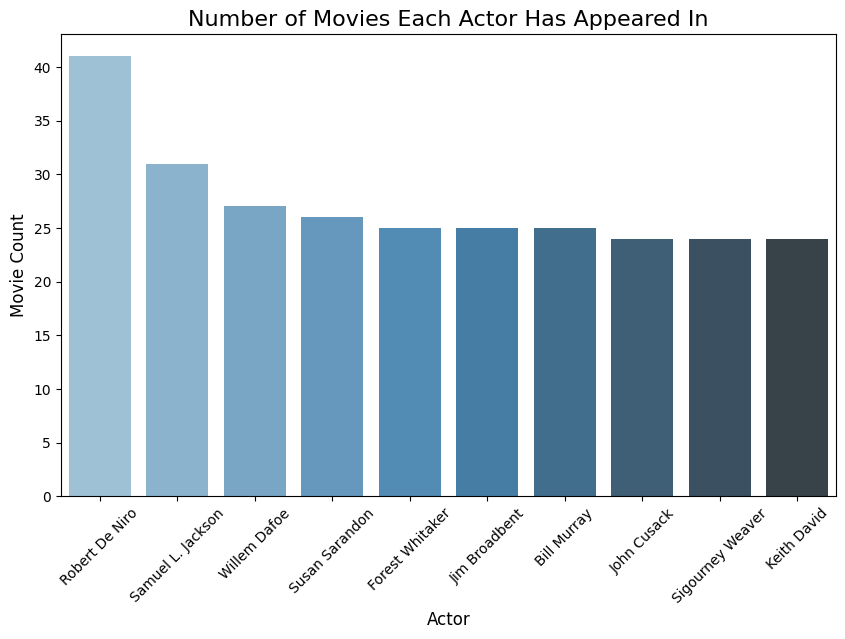

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create the data as a dictionary
data = {
    'Actor': ['Robert De Niro', 'Samuel L. Jackson', 'Willem Dafoe', 'Susan Sarandon',
              'Forest Whitaker', 'Jim Broadbent', 'Bill Murray', 'John Cusack',
              'Sigourney Weaver', 'Keith David'],
    'Movie Count': [41, 31, 27, 26, 25, 25, 25, 24, 24, 24]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Actor', y='Movie Count', data=df, palette='Blues_d')

# Customize the plot
plt.title('Number of Movies Each Actor Has Appeared In', fontsize=16)
plt.xlabel('Actor', fontsize=12)
plt.ylabel('Movie Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()



# Insights
This list highlights veteran actors with extensive film careers, led by Robert De Niro (41 films) and Samuel L. Jackson (31 films). Willem Dafoe, Susan Sarandon, and others follow closely, with each actor known for their versatility across genres. Despite a male-dominated list, actresses like Sarandon and Sigourney Weaver have made significant contributions to cinema.

Which were the top 10 movies that were released in 2015?

In [47]:
import pandas as pd

# Step 1: Convert the 'release_date' column to datetime format
movies_with_credits['release_date'] = pd.to_datetime(movies_with_credits['release_date'])

# Step 2: Filter movies released in 2015
filtered_movies_2015 = movies_with_credits[
    (movies_with_credits['release_date'] >= '2015-01-01') &
    (movies_with_credits['release_date'] <= '2015-12-31')
]

# Step 3: Sort the filtered movies by release date
sorted_movies_2015 = filtered_movies_2015.sort_values(by='release_date')

# Step 4: Select the top 10 movies
top_10_movies_2015 = sorted_movies_2015.head(10)

# Step 5: Extract the title and year of release
top_10_movies_2015['year'] = top_10_movies_2015['release_date'].dt.year
top_10_movies_2015 = top_10_movies_2015[['title', 'year']]

# Display the top 10 movies
print(top_10_movies_2015)


                   title  year
4681        Reality Show  2015
4068           Sharkskin  2015
4659          Horse Camp  2015
1674           Wild Card  2015
4783            Backmask  2015
2752          Ex Machina  2015
3746   The Boy Next Door  2015
3572  The Lazarus Effect  2015
2865     Project Almanac  2015
4074          It Follows  2015


<ipython-input-47-2905ca94a6b6>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_movies_2015['year'] = top_10_movies_2015['release_date'].dt.year


# Insights
Diverse Release Dates: The movies were released throughout the year, from January to December, indicating a consistent production and release schedule.

Early and Late Releases: There are movies released at the beginning of the year (e.g., January 1st) and at the end of the year (e.g., December 12th), which might suggest strategic release timings to capture different audience segments.

Mid-Year Peaks: Several movies were released around mid-year (e.g., May, June, July), which is often a popular time for movie releases due to summer holidays in many regions.

Which movies were the highest grossing in revenue?

In [33]:
import pandas as pd

# Step 1: Ensure the 'revenue' column is numeric
movies_with_credits['revenue'] = pd.to_numeric(movies_with_credits['revenue'], errors='coerce')

# Step 2: Sort the DataFrame by the 'revenue' column in descending order
highest_grossing_movies = movies.sort_values(by='revenue', ascending=False)

# Step 3: Display the top 10 highest-grossing movies
top_10_highest_grossing = highest_grossing_movies[['title', 'revenue']].head(10)

# Print the result
print(top_10_highest_grossing)


                          title     revenue
0                        Avatar  2787965087
25                      Titanic  1845034188
16                 The Avengers  1519557910
28               Jurassic World  1513528810
44                    Furious 7  1506249360
7       Avengers: Age of Ultron  1405403694
124                      Frozen  1274219009
31                   Iron Man 3  1215439994
546                     Minions  1156730962
26   Captain America: Civil War  1153304495


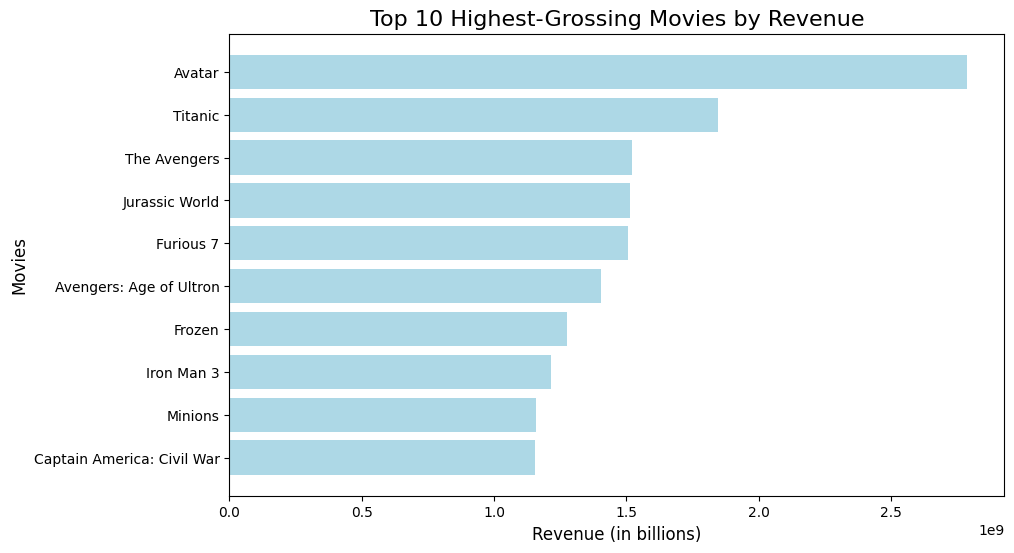

In [34]:
import matplotlib.pyplot as plt

# Step 4: Plot a bar chart for the top 10 highest-grossing movies
plt.figure(figsize=(10, 6))
plt.barh(top_10_highest_grossing['title'], top_10_highest_grossing['revenue'], color='lightblue')
plt.title('Top 10 Highest-Grossing Movies by Revenue', fontsize=16)
plt.xlabel('Revenue (in billions)', fontsize=12)
plt.ylabel('Movies', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest-grossing movie on top
plt.show()

# Insights
Avatar, Titanic and the Avengers were the top 3 highest grossing movies with billions of dollars in revenue.
This indicates that the fans of these movies showed up in large numbers to watch the movies as soon as they were released compared to other releases.


Which production companies produce the most movies?

In [38]:
import pandas as pd

# Step 1: Convert the 'production_companies' column to a list of dictionaries if it's a string
def safe_eval(val):
    if isinstance(val, str):
        return eval(val)
    return val

movies_with_credits['production_companies'] = movies_with_credits['production_companies'].apply(safe_eval)

# Step 2: Explode the production companies to have one company per row
movies_exploded = movies_with_credits.explode('production_companies')

# Step 3: Extract the 'name' field of each production company
movies_exploded['company_name'] = movies_exploded['production_companies'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

# Step 4: Count the occurrences of each production company
company_counts = movies_exploded['company_name'].value_counts()

# Display the top 10 production companies by the number of movies produced
top_10_companies = company_counts.head(10)
print(top_10_companies)




company_name
Universal Pictures                        181
Paramount Pictures                        175
Warner Bros.                              163
New Line Cinema                           130
Twentieth Century Fox Film Corporation    119
Columbia Pictures                         105
Metro-Goldwyn-Mayer (MGM)                  92
Miramax Films                              77
Touchstone Pictures                        76
United Artists                             61
Name: count, dtype: int64


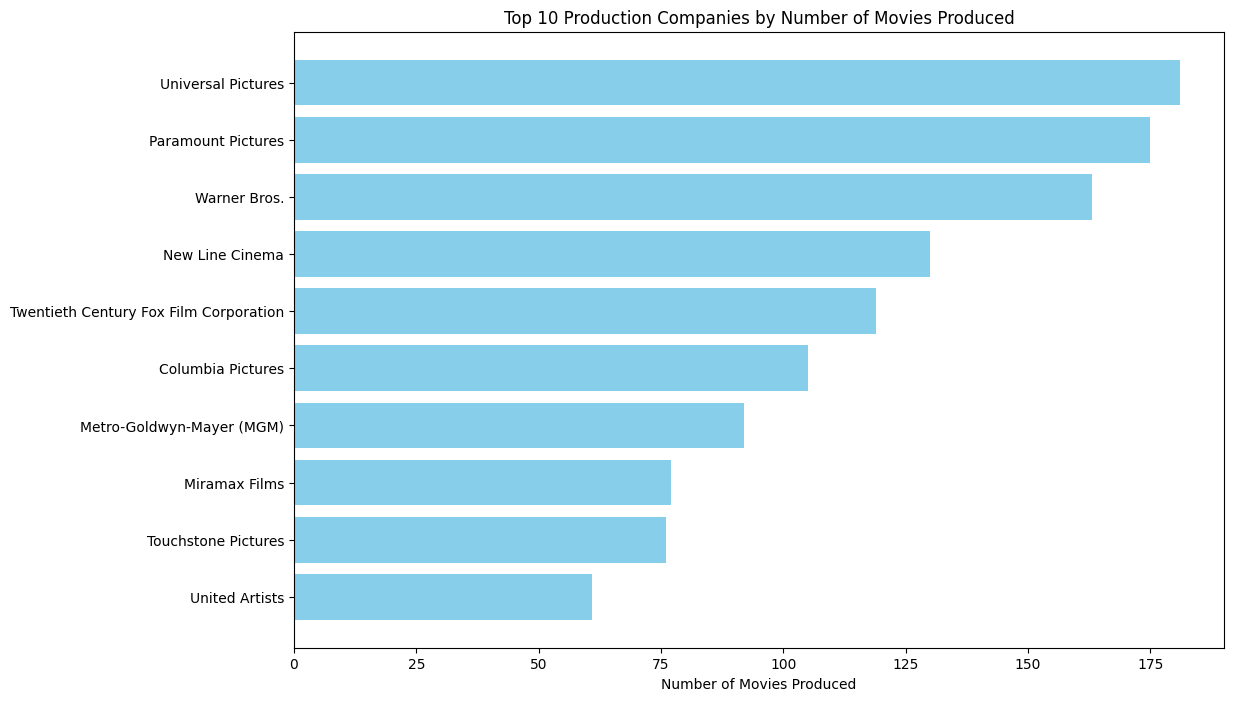

In [39]:
import matplotlib.pyplot as plt

# Data from your output
companies = [
    "Universal Pictures", "Paramount Pictures", "Warner Bros.", "New Line Cinema",
    "Twentieth Century Fox Film Corporation", "Columbia Pictures",
    "Metro-Goldwyn-Mayer (MGM)", "Miramax Films", "Touchstone Pictures", "United Artists"
]
movie_counts = [181, 175, 163, 130, 119, 105, 92, 77, 76, 61]

# Create the bar plot
plt.figure(figsize=(12, 8))
plt.barh(companies, movie_counts, color='skyblue')
plt.xlabel('Number of Movies Produced')
plt.title('Top 10 Production Companies by Number of Movies Produced')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest count at the top
plt.show()


# Insights
Universal Pictures comes first with 181 movies produced. This indicates a strong presence and influence in the film industry.

Paramount Pictures and Warner Bros. follow closely, with 175 and 163 movies respectively. These companies are also major players in the industry, producing a significant number of films.

New Line Cinema and Twentieth Century Fox Film Corporation have produced 130 and 119 movies respectively, showcasing their contributions to the film market.

Columbia Pictures has produced 105 movies, indicating its role as a key player in the industry.

Metro-Goldwyn-Mayer (MGM), Miramax Films, Touchstone Pictures, and United Artists round out the list, each with a notable number of productions ranging from 61 to 92 movies.

Which are the most recent top 10 movies produced by Universal Pictures?

In [17]:
import pandas as pd

# Step 1: Convert the 'release_date' column to datetime format
movies_with_credits['release_date'] = pd.to_datetime(movies_with_credits['release_date'])

# Step 2: Sort the movies by release date in descending order
sorted_movies = movies_with_credits.sort_values(by='release_date', ascending=False)

# Step 3: Select the top 10 most recent movies
top_10_recent_movies = sorted_movies.head(10)

# Step 4: Extract the title and year of release
top_10_recent_movies['year'] = top_10_recent_movies['release_date'].dt.year
top_10_recent_movies = top_10_recent_movies[['title', 'year']]

# Display the top 10 most recent movies
print(top_10_recent_movies)


                      title  year
3408  Two Lovers and a Bear  2016
3302             Mr. Church  2016
3249                  Kicks  2016
4720  The Birth of a Nation  2016
4036              Antibirth  2016
2273         Hands of Stone  2016
3013          Pete's Dragon  2016
2305            Indignation  2016
2112               Bad Moms  2016
2167                  Nerve  2016


<ipython-input-17-88e6fcc73efb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_recent_movies['year'] = top_10_recent_movies['release_date'].dt.year


# Insights
The list includes a variety of genres, from drama and biographical films to fantasy and comedy. For example:
Two Lovers and a Bear is a romantic drama, Mr. Church is a drama based on a true story and Pete’s Dragon is a fantasy adventure films. This gives many different options to the fans as they have a wide variety to choose from dependig on what they love.

All the movies listed were released in 2016, indicating a productive year for the film industry. This could reflect a trend or a particularly strong year for movie releases.

# Data Preprocessing

Data preprocessing involves cleaning, transforming, and organizing raw data into a format that can be effectively used for analysis and model building. Some of the steps include checking for missing values, encoding, feature engineering among others.

**Checking for missing values and handling missing data**

In [26]:
movies_with_credits.isnull().sum()

,0
budget,0
genres,0
id,0
popularity,0
production_companies,0
release_date,0
revenue,0
overview,0
vote_average,0
title,0


In [27]:
movies_with_credits.dropna(inplace=True)

**Feature Engineering**

This involves creating new features or modifying existing ones to make the data more informative (e.g., extracting year from release_date).

1. Ensure all columns have the appropriate data types.

In [29]:
# Convert 'release_date' to datetime
movies_with_credits['release_date'] = pd.to_datetime(movies_with_credits['release_date'], errors='coerce')

# Ensure other columns are in the correct format
movies_with_credits['budget'] = pd.to_numeric(movies_with_credits['budget'], errors='coerce')
movies_with_credits['revenue'] = pd.to_numeric(movies_with_credits['revenue'], errors='coerce')

2. Feature Extraction

In [30]:
# Extract year from release_date
movies_with_credits['release_year'] = movies_with_credits['release_date'].dt.year

# Calculate Return on Investment (ROI)
movies_with_credits['roi'] = (movies_with_credits['revenue'] - movies_with_credits['budget']) / movies_with_credits['budget']

# One-Hot Encoding

This is a technique used to convert categorical variables into a numerical format that machine learning models can understand. This way, machine learning models can interpret categorical data without assuming any ordinal relationship between categories.


Explode the lists into separate rows, allowing each element to be treated individually for one-hot encoding.

In [31]:
# Explode the lists into separate rows for one-hot encoding
movies_genres = movies.explode('genres')
movies_genres['genre_name'] = movies_genres['genres'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

movies_companies = movies.explode('production_companies')
movies_companies['company_name'] = movies_companies['production_companies'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

movies_cast = movies.explode('cast')
movies_cast['cast_name'] = movies_cast['cast'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

movies_crew = movies.explode('crew')
movies_crew['crew_name'] = movies_crew['crew'].apply(lambda x: x['name'] if isinstance(x, dict) else None)

In [32]:
# One-hot encode the processed columns
genres_encoded = pd.get_dummies(movies_genres['genre_name'], prefix='genre')
companies_encoded = pd.get_dummies(movies_companies['company_name'], prefix='company')
cast_encoded = pd.get_dummies(movies_cast['cast_name'], prefix='cast')
crew_encoded = pd.get_dummies(movies_crew['crew_name'], prefix='crew')

In [33]:
# Reset the index of the original DataFrame and the encoded DataFrames
movies_with_credits = movies.reset_index(drop=True)
genres_encoded = genres_encoded.reset_index(drop=True)
companies_encoded = companies_encoded.reset_index(drop=True)
cast_encoded = cast_encoded.reset_index(drop=True)
crew_encoded = crew_encoded.reset_index(drop=True)


In [34]:
# Concatenate genres_encoded first
movies_with_credits = pd.concat([movies_with_credits, genres_encoded], axis=1)
movies_with_credits = movies_with_credits.drop(['genres'], axis=1, errors='ignore')

# Then concatenate companies_encoded
movies_with_credits = pd.concat([movies, companies_encoded], axis=1)
movies_with_credits = movies_with_credits.drop(['production_companies'], axis=1, errors='ignore')

# Continue with cast_encoded and crew_encoded
movies_with_credits = pd.concat([movies, cast_encoded], axis=1)
movies_with_credits = movies_with_credits.drop(['cast'], axis=1, errors='ignore')

movies_with_credits = pd.concat([movies_with_credits, crew_encoded], axis=1)
movies_with_credits = movies_with_credits.drop(['crew'], axis=1, errors='ignore')

# Feature Scaling

Scaling numeric features is necessary to ensure they are on the same scale.

In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Identify numeric features
numeric_features = ['budget', 'revenue', 'popularity','vote_average']

# Check for infinite values and replace them with NaN
movies_with_credits[numeric_features] = movies_with_credits[numeric_features].replace([np.inf, -np.inf], np.nan)

# Optionally, drop rows with NaN values in numeric features
movies_with_credits = movies_with_credits.dropna(subset=numeric_features)

# Scale the numeric features
scaler = StandardScaler()
movies_with_credits.loc[:, numeric_features] = scaler.fit_transform(movies_with_credits[numeric_features])

# Check the result
print("Scaling complete. Here's a preview:")
print(movies[numeric_features].head())

Scaling complete. Here's a preview:
      budget     revenue  popularity  vote_average
0  237000000  2787965087  150.437577           7.2
1  300000000   961000000  139.082615           6.9
2  245000000   880674609  107.376788           6.3
3  250000000  1084939099  112.312950           7.6
4  260000000   284139100   43.926995           6.1


# MODELLING

# Cosine Similarity
Cosine similarity is a metric used to measure how similar two vectors are, regardless of their magnitude. It calculates the cosine of the angle between two vectors, and the value ranges from -1 to 1:

1 means vectors are identical and point in the same direction.
0 means vectors have no similarity.
-1 means vectors are diametrically opposed meaning that they are completely dissimilar.

In this movie recommender system project, each movie can be represented as a vector in a high-dimensional space, where each dimension could correspond to a feature like genre, cast, production companies, or other numerical values like budget, popularity, etc.

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

# Select the final features for similarity calculation (already concatenated and encoded)
features_for_similarity = movies_with_credits[['budget', 'popularity', 'revenue', 'vote_average']]

# Compute the cosine similarity matrix based on these features
cosine_sim_matrix = cosine_similarity(features_for_similarity)

# Create a DataFrame to map the movie indices with the similarity scores
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=movies_with_credits['title'], columns=movies_with_credits['title'])

# Preview the similarity scores for a specific movie (example for 'Inception')
movie_title = 'Inception'
similar_movies = cosine_sim_df[movie_title].sort_values(ascending=False).head(10)

print(f"Movies similar to {movie_title}:\n", similar_movies)



Movies similar to Inception:
 title
Inception                     1.000000
The Dark Knight               0.998905
Monsters, Inc.                0.998358
Iron Man                      0.995548
Terminator 2: Judgment Day    0.995290
Ant-Man                       0.992427
Cinderella                    0.991274
Die Hard 2                    0.989719
The Revenant                  0.988285
Men in Black                  0.988261
Name: Inception, dtype: float64


# RECOMMENDATION

In [37]:
# Create a function to get movie recommendations based on the cosine similarity matrix
def get_recommendations(title, cosine_sim_matrix, movies_with_credits):
    # Get the index of the movie that matches the title
    idx = movies_with_credits.index[movies_with_credits['title'] == title][0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the indices of the most similar movies (excluding the first one, which is the same movie)
    movie_indices = [i[0] for i in sim_scores[1:11]]  # Top 10 similar movies

    # Return the top 10 most similar movies
    return movies_with_credits['title'].iloc[movie_indices]

# Test the recommendation system
print(get_recommendations('The Matrix', cosine_sim_matrix, movies_with_credits))


1557        The Princess Diaries
635                    Apollo 13
1163             The Conjuring 2
1390       Friends with Benefits
883          Catch Me If You Can
1152             American Hustle
1105                        Argo
809                 Forrest Gump
824     The Pursuit of Happyness
631                      Ice Age
Name: title, dtype: object
